# Import requirements

In [9]:
import sys
sys.path.append("../src")
import os
from scipy.io import loadmat
import torch
import numpy as np
import matplotlib.pyplot as plt
from plotUtils import plotTrueAndEstimatedLatents
from kernels import PeriodicKernel, ExponentialQuadraticKernel
import svGPFAModelFactory
from svEM import SVEM

# Load data and initial values

In [2]:
yNonStackedFilename = os.path.expanduser("data/YNonStacked.mat")
dataFilename = os.path.expanduser("data/demo_PointProcess.mat")

mat = loadmat(yNonStackedFilename)
YNonStacked = mat['YNonStacked']

mat = loadmat(dataFilename)
nLatents = len(mat['Z0'])
nTrials = mat['Z0'][0,0].shape[2]
qMu0 = [torch.from_numpy(mat['q_mu0'][(0,i)]).type(torch.DoubleTensor).permute(2,0,1) for i in range(nLatents)]
qSVec0 = [torch.from_numpy(mat['q_sqrt0'][(0,i)]).type(torch.DoubleTensor).permute(2,0,1) for i in range(nLatents)]
qSDiag0 = [torch.from_numpy(mat['q_diag0'][(0,i)]).type(torch.DoubleTensor).permute(2,0,1) for i in range(nLatents)]
Z0 = [torch.from_numpy(mat['Z0'][(i,0)]).type(torch.DoubleTensor).permute(2,0,1) for i in range(nLatents)]
C0 = torch.from_numpy(mat["C0"]).type(torch.DoubleTensor)
b0 = torch.from_numpy(mat["b0"]).type(torch.DoubleTensor).squeeze()
legQuadPoints = torch.from_numpy(mat['ttQuad']).type(torch.DoubleTensor).permute(2, 0, 1)
legQuadWeights = torch.from_numpy(mat['wwQuad']).type(torch.DoubleTensor).permute(2, 0, 1)
kernelNames = mat["kernelNames"]
hprs0 = mat["hprs0"]
testTimes = torch.from_numpy(mat['testTimes']).type(torch.DoubleTensor).squeeze()
trueLatents = [[torch.from_numpy(mat['trueLatents'][tr,k]).type(torch.DoubleTensor) 
                for tr in range(nTrials)] for k in range(nLatents)]

# Create kernels

In [3]:
kernels = [[None] for k in range(nLatents)]
for k in range(nLatents):
    if np.char.equal(kernelNames[0,k][0], "PeriodicKernel"):
        kernels[k] = PeriodicKernel(scale=1.0)
    elif np.char.equal(kernelNames[0,k][0], "rbfKernel"):
        kernels[k] = ExponentialQuadraticKernel(scale=1.0)
    else:
        raise ValueError("Invalid kernel name: %s"%(kernelNames[k]))

# Set parameters

In [4]:
kernelsParams0 = [[None] for k in range(nLatents)]
for k in range(nLatents):
    if np.char.equal(kernelNames[0,k][0], "PeriodicKernel"):
        kernelsParams0[k] = torch.tensor([float(hprs0[k,0][0]),
                                          float(hprs0[k,0][1])],
                                         dtype=torch.double)
    elif np.char.equal(kernelNames[0,k][0], "rbfKernel"):
        kernelsParams0[k] = torch.tensor([float(hprs0[k,0][0])],
                                         dtype=torch.double)
    else:
        raise ValueError("Invalid kernel name: %s"%(kernelNames[k]))
qUParams0 = {"qMu0": qMu0, "qSVec0": qSVec0, "qSDiag0": qSDiag0}
qHParams0 = {"C0": C0, "d0": b0}
kmsParams0 = {"kernelsParams0": kernelsParams0,
              "inducingPointsLocs0": Z0}
initialParams = {"svPosteriorOnIndPoints": qUParams0,
                 "kernelsMatricesStore": kmsParams0,
                 "svEmbedding": qHParams0}
quadParams = {"legQuadPoints": legQuadPoints,
              "legQuadWeights": legQuadWeights}
optimParams = {"emMaxNIter":20, 
               "eStepMaxNIter":100, 
               "mStepModelParamsMaxNIter":100, 
               "mStepKernelParamsMaxNIter":100, 
               "mStepKernelParamsLR":1e-5, 
               "mStepIndPointsMaxNIter":100}        

# Create model

In [5]:
    model = svGPFAModelFactory.SVGPFAModelFactory.buildModel(
        conditionalDist=svGPFAModelFactory.PointProcess,
        linkFunction=svGPFAModelFactory.ExponentialLink,
        embeddingType=svGPFAModelFactory.LinearEmbedding)

# Maximize the Lower Bound
<span style="color:red">(Warning: with the parameters above, this step takes around 15 minutes)</span>

In [6]:
svEM = SVEM()
maxRes = svEM.maximize(model=model, measurements=YNonStacked,
                       kernels=kernels, initialParams=initialParams,
                       quadParams=quadParams, optimParams=optimParams)


Iteration 00, E-Step start
Iteration: 0, negative lower bound: 6180.619714
Iteration: 10, negative lower bound: 5897.443745
Iteration: 20, negative lower bound: 5842.268679
Iteration: 30, negative lower bound: 5817.135911
Iteration: 40, negative lower bound: 5796.152578
Iteration: 50, negative lower bound: 5778.050121
Iteration: 60, negative lower bound: 5763.004901
Iteration: 70, negative lower bound: 5749.780909
Iteration: 80, negative lower bound: 5737.635142
Iteration: 90, negative lower bound: 5726.199029
Iteration 00, E-Step end: 5716.393521
Iteration 00, M-Step Model Params start
Iteration: 0, negative sum of expected log likelihood: 5430.994394
Iteration: 10, negative sum of expected log likelihood: 5410.627305
Iteration: 20, negative sum of expected log likelihood: 5391.260070
Iteration: 30, negative sum of expected log likelihood: 5372.913582
Iteration: 40, negative sum of expected log likelihood: 5355.551136
Iteration: 50, negative sum of expected log likelihood: 5339.099837

Iteration: 30, negative sum of expected log likelihood: 4723.776873
Iteration: 40, negative sum of expected log likelihood: 4720.697154
Iteration: 50, negative sum of expected log likelihood: 4717.927309
Iteration: 60, negative sum of expected log likelihood: 4715.420345
Iteration: 70, negative sum of expected log likelihood: 4713.139652
Iteration: 80, negative sum of expected log likelihood: 4711.057485
Iteration: 90, negative sum of expected log likelihood: 4709.152219
Iteration 03, M-Step Model Params end: 4707.573966
Iteration 03, M-Step Kernel Params start
Iteration: 0, negative lower bound: 4915.538278
Iteration: 10, negative lower bound: 4915.514298
Iteration: 20, negative lower bound: 4915.476454
Iteration: 30, negative lower bound: 4915.448088
Iteration: 40, negative lower bound: 4915.423224
Iteration: 50, negative lower bound: 4915.399871
Iteration: 60, negative lower bound: 4915.377613
Iteration: 70, negative lower bound: 4915.355845
Iteration: 80, negative lower bound: 4915

Iteration: 40, negative lower bound: 4806.989582
Iteration: 50, negative lower bound: 4806.972526
Iteration: 60, negative lower bound: 4806.956327
Iteration: 70, negative lower bound: 4806.940040
Iteration: 80, negative lower bound: 4806.923656
Iteration: 90, negative lower bound: 4806.907465
Iteration 06, M-Step Kernel Params end: 4806.892948
Iteration 06, M-Step Ind Points start
Iteration: 0, negative lower bound: 4806.891338
Iteration: 10, negative lower bound: 4834.717025
Iteration: 20, negative lower bound: 4816.057514
Iteration: 30, negative lower bound: 4811.231683
Iteration: 40, negative lower bound: 4808.936474
Iteration: 50, negative lower bound: 4807.284638
Iteration: 60, negative lower bound: 4806.082305
Iteration: 70, negative lower bound: 4805.079862
Iteration: 80, negative lower bound: 4804.321342
Iteration: 90, negative lower bound: 4803.761669
Iteration 06, M-Step Ind Points end: 4803.378729
Iteration 07, E-Step start
Iteration: 0, negative lower bound: 4803.342505
Ite

Iteration: 80, negative lower bound: 4760.607353
Iteration: 90, negative lower bound: 4760.069223
Iteration 09, M-Step Ind Points end: 4759.714405
Iteration 10, E-Step start
Iteration: 0, negative lower bound: 4759.681053
Iteration: 10, negative lower bound: 4759.605223
Iteration: 20, negative lower bound: 4757.824686
Iteration: 30, negative lower bound: 4756.786201
Iteration: 40, negative lower bound: 4756.093767
Iteration: 50, negative lower bound: 4755.470328
Iteration: 60, negative lower bound: 4754.892092
Iteration: 70, negative lower bound: 4754.347171
Iteration: 80, negative lower bound: 4753.830392
Iteration: 90, negative lower bound: 4753.338477
Iteration 10, E-Step end: 4752.916090
Iteration 10, M-Step Model Params start
Iteration: 0, negative sum of expected log likelihood: 4572.092533
Iteration: 10, negative sum of expected log likelihood: 4571.672370
Iteration: 20, negative sum of expected log likelihood: 4571.634834
Iteration: 30, negative sum of expected log likelihood: 

Iteration: 10, negative sum of expected log likelihood: 4556.730078
Iteration: 20, negative sum of expected log likelihood: 4556.704548
Iteration: 30, negative sum of expected log likelihood: 4556.695550
Iteration: 40, negative sum of expected log likelihood: 4556.693355
Iteration: 50, negative sum of expected log likelihood: 4556.692538
Iteration: 60, negative sum of expected log likelihood: 4556.692125
Iteration: 70, negative sum of expected log likelihood: 4556.692002
Iteration: 80, negative sum of expected log likelihood: 4556.691955
Iteration: 90, negative sum of expected log likelihood: 4556.691939
Iteration 13, M-Step Model Params end: 4556.691933
Iteration 13, M-Step Kernel Params start
Iteration: 0, negative lower bound: 4733.548998
Iteration: 10, negative lower bound: 4733.834463
Iteration: 20, negative lower bound: 4733.560889
Iteration: 30, negative lower bound: 4733.492574
Iteration: 40, negative lower bound: 4733.488239
Iteration: 50, negative lower bound: 4733.477298
Ite

Iteration: 10, negative lower bound: 4723.215093
Iteration: 20, negative lower bound: 4722.845252
Iteration: 30, negative lower bound: 4722.764256
Iteration: 40, negative lower bound: 4722.764563
Iteration: 50, negative lower bound: 4722.753705
Iteration: 60, negative lower bound: 4722.743062
Iteration: 70, negative lower bound: 4722.734122
Iteration: 80, negative lower bound: 4722.726322
Iteration: 90, negative lower bound: 4722.718915
Iteration 16, M-Step Kernel Params end: 4722.712175
Iteration 16, M-Step Ind Points start
Iteration: 0, negative lower bound: 4722.711435
Iteration: 10, negative lower bound: 4794.329417
Iteration: 20, negative lower bound: 4736.234179
Iteration: 30, negative lower bound: 4732.895009
Iteration: 40, negative lower bound: 4727.568259
Iteration: 50, negative lower bound: 4724.932207
Iteration: 60, negative lower bound: 4723.662584
Iteration: 70, negative lower bound: 4723.131507
Iteration: 80, negative lower bound: 4722.733487
Iteration: 90, negative lower

Iteration: 50, negative lower bound: 4718.542825
Iteration: 60, negative lower bound: 4717.547803
Iteration: 70, negative lower bound: 4716.851010
Iteration: 80, negative lower bound: 4716.237781
Iteration: 90, negative lower bound: 4715.586526
Iteration 19, M-Step Ind Points end: 4715.239020


# Predict latents at new times

In [7]:
muK, varK = model.predictLatents(newTimes=testTimes)

# Plot latents estimates for one trial

<IPython.core.display.Javascript object>


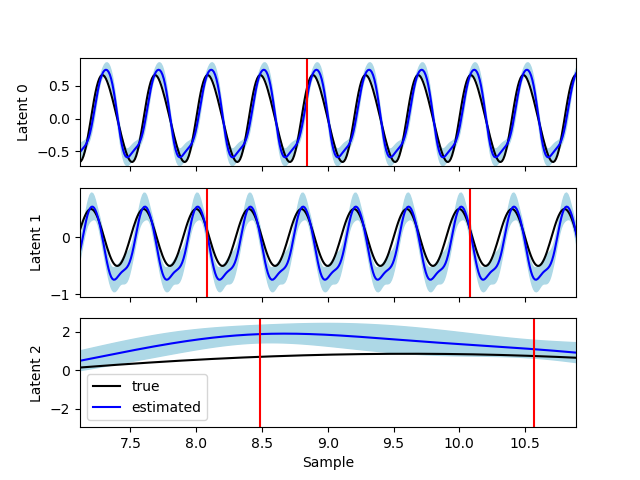

No handles with labels found to put in legend.
No handles with labels found to put in legend.


In [13]:
%matplotlib notebook
trialToPlot=4
indPointsLocs = model.getIndPointsLocs()
nLatents = muK.shape[2]
timesToPlot = testTimes.numpy()
f, axes = plt.subplots(nLatents, 1, sharex=True)
for k in range(nLatents):
    trueLatentToPlot = trueLatents[k][trialToPlot].numpy().squeeze()
    muKToPlot = muK[trialToPlot,:,k].detach().numpy()
    errorToPlot = varK[trialToPlot,:,k].sqrt().detach().numpy()
    axes[k].plot(timesToPlot, trueLatentToPlot, label="true", color="black")
    axes[k].plot(timesToPlot, muKToPlot, label="estimated", color="blue")
    axes[k].fill_between(timesToPlot, muKToPlot-errorToPlot,
                          muKToPlot+errorToPlot, color="lightblue")
    for i in range(indPointsLocs[k].shape[1]):
        axes[k].axvline(x=indPointsLocs[k][trialToPlot,i, 0], color="red")
        axes[k].set_ylabel("Latent %d"%(k))
    axes[-1].set_xlabel("Sample")
    axes[-1].legend()
    plt.xlim(left=np.min(timesToPlot)-1, right=np.max(timesToPlot)+1)
    plt.show()